In [1]:
%cd ..
import numpy as np
from tqdm import tqdm

/Users/paulwilson/projects/tmp/leisure-learner


In [2]:
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'

In [16]:
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class GridworldConfig:
    height: int
    width: int 
    rewards: List[Tuple[float, int, int]]
    
def gridworld_step(position: Tuple[int, int], action: int, config: GridworldConfig):
    x, y = position
    
    if action == 0:
        y = y 
    elif action == 1:
        y = y - 1 
    elif action == 2: 
        y = y + 1
    else: 
        raise ValueError(f'action {action} unknown.')
    
    x = x - 1
    
    # check if in terminal state:
    if x < 0 or y < 0 or y >= config.width:
        return (0, 0), 0, True, {}
        
    reward = 0
    for value, x_, y_ in config.rewards: 
        if (x, y) == (x_, y_):
            reward += value
    
    return (x, y), reward, False, {}

def gridworld_initial_position(config: GridworldConfig):
    initial_x = config.height - 1
    initial_y = np.random.randint(0, config.width)
    return initial_x, initial_y


In [4]:
config = GridworldConfig(height=20, width=10, rewards=[[1,0,7],[1,4,5]])
position = 19, 5

## Baseline Q-learning algorithm: 

In [17]:
import numpy as np


def eGreedy(Q, state, eps):
    r = np.random.random()
    if r < eps:
        action_space = Q.shape[2]
        a = np.random.randint(action_space)
    else:
        x = Q[state[0],state[1],:]
        a = np.random.choice(np.where(x == x.max())[0])
    
    return a


def Qlearn(Q,s1,action,rew,disct,s2,alpha):

    target = rew + disct * Q[s2[0],s2[1],:].max()

    delta = Q[s1[0],s1[1],action] - target
    qdrop = Q[s1[0],s1[1],action] - disct*Q[s2[0],s2[1],:].max()
    ratio = Q[s1[0],s1[1],:].max() / (disct*Q[s2[0],s2[1],:].max() + 0.00001)
    
    if rew > 0:
        ratio = 0

    Q[s1[0],s1[1],action] = Q[s1[0],s1[1],action] - alpha*delta

    return Q, delta, qdrop, ratio


def play_baseline(gridworld_config, steps, Q, alpha, eps, disct):

    epicount = 0
    epirew = 0
    episteps = 0
    score = np.zeros(steps)
    episode_steps = np.zeros(int(steps//10))
    episode_rewards = np.zeros(int(steps//10))

    state = gridworld_initial_position(gridworld_config)
    
    episode_pbar = tqdm(desc='episodes')
    
    for i in range(steps):
        
        s1 = state
        action = eGreedy(Q, s1, eps)
        s2, rew, done, info = gridworld_step(s1, action, gridworld_config)
        
        if done: 
            Q, delta, qdrop, ratio = Qlearn(Q,s1,action,rew,0,s2,alpha)
        else:  
            Q, delta, qdrop, ratio = Qlearn(Q,s1,action,rew,disct,s2,alpha)
            
        epirew += rew
        episteps += 1
        
        if done:
            
            episode_pbar.update()
            episode_steps[epicount] = episteps
            episode_rewards[epicount] = epirew
            epicount += 1

            # Print end of episode info 
            if epicount%100==0:
                episode_pbar.set_postfix({
                    'reward':epirew,
                    'steps':episteps
                })

            epirew = 0
            episteps = 0

        score[i] = rew
        state = gridworld_initial_position(config) if done else s2
        
    return (np.cumsum(score), Q)

    

# Baseline experiment:

episodes: 15144it [00:04, 3507.36it/s, reward=0, steps=19]
episodes: 15704it [00:04, 3641.15it/s, reward=2, steps=20]
episodes: 15110it [00:04, 3302.06it/s, reward=1, steps=20]


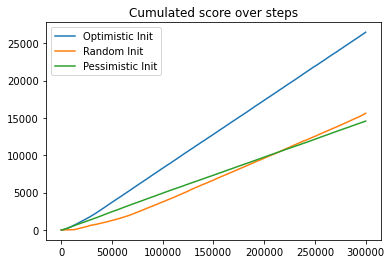

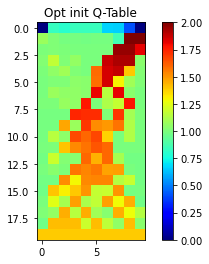

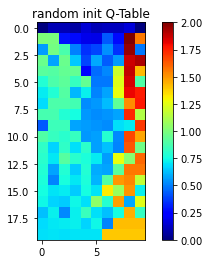

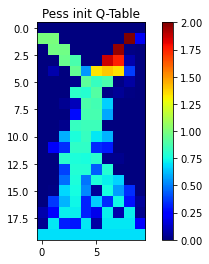

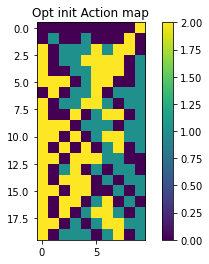

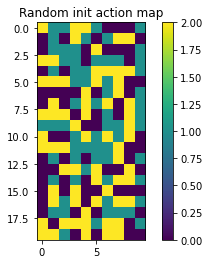

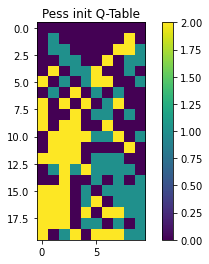

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from src.environments.GridWorld import GridWorld

eps = 0.05
alpha = 0.01
steps = 300000

world_dim = [20,10]
rewards = [[1,0,0],[2,0,9]]

env_config = GridworldConfig(world_dim[0], world_dim[1], rewards)

dim = (20,10,3)

Q1 = np.ones(dim)

score_opt, Q1 = play_baseline(env_config, steps, Q1, alpha, eps, .98)

Q2 = np.random.rand(*dim)
score_rand, Q2 = play_baseline(env_config, steps, Q2, alpha, eps, .98)

Q3 = np.zeros(dim)
score_pess, Q3 = play_baseline(env_config, steps, Q3, alpha, eps, .98)

plt.plot(score_opt, label= "Optimistic Init" )
plt.plot(score_rand, label= "Random Init" )
plt.plot(score_pess, label= "Pessimistic Init" )
plt.title("Cumulated score over steps")
plt.legend()
plt.show()

max_opt_val = np.max(Q1,axis=2)
plt.imshow(max_opt_val[:,:], vmin=0,vmax=2,cmap="jet")
plt.colorbar()
plt.title("Opt init Q-Table")
plt.show()

max_rand_val = np.max(Q2,axis=2)
plt.imshow(max_rand_val[:,:], vmin=0,vmax=2 ,cmap="jet")
plt.colorbar()
plt.title("random init Q-Table")
plt.show()

max_pess_val = np.max(Q3,axis=2)
plt.imshow(max_pess_val[:,:], vmin=0,vmax=2, cmap="jet")
plt.colorbar()
plt.title("Pess init Q-Table")
plt.show()

action_opt = np.argmax(Q1,axis=2)
plt.imshow(action_opt[:,:])
plt.colorbar()
plt.title("Opt init Action map")
plt.show()

action_rand = np.argmax(Q2,axis=2)
plt.imshow(action_rand[:,:])
plt.colorbar()
plt.title("Random init action map")
plt.show()

action_pess = np.argmax(Q3,axis=2)
plt.imshow(action_pess[:,:])
plt.colorbar()
plt.title("Pess init Q-Table")
plt.show()



## Freetime algorithm

In [58]:
def play_freetime(gridworld_config: GridworldConfig, steps, Q, alpha, eps, disct):

    epicount = 0
    epirew = 0
    episteps = 0
    epifree = 0
    score = np.zeros(steps)
    episode_steps = np.zeros(int(steps//10))
    episode_rewards = np.zeros(int(steps//10))
    episode_time = np.zeros(int(steps//10))

    F = np.ones((gridworld_config.height, gridworld_config.width, 3))

    state = gridworld_initial_position(gridworld_config)
    
    for i in range(steps):
        s1 = state

        # Check if an action has free time
        state_actions = F[s1[0],s1[1], :]
        time = np.where(state_actions>=1)[0]
        
        if len(time) >= 1:
            # play random on free time 
            # *Only amoung those actions with Freetime
            #action_space = Q.shape[3]
            #action = np.random.randint(action_space)
            r = np.random.random()
            if r < eps:
                action_space = Q.shape[2]
                action = np.random.randint(action_space)
            else: 
                action = np.random.choice(time)
        else:
            # Play egreedy
            action = eGreedy(Q, s1, eps)
        
        # play our action, get new state and disct,
        s2, rew, done, info = gridworld_step(s1, action, gridworld_config)
        
        # Learn Q
        if not done:
            Q, delta, qdrop, ratio = Qlearn(Q, s1, action, rew, disct, s2, alpha)
        else: 
            Q, delta, qdrop, ratio = Qlearn(Q, s1, action, rew, 0, s2, alpha)
            
        # Learn F 
        Frew = int(ratio < 1)
        Fdisct = int(Frew)
        
        if not done:
            F = Qlearn(F, s1, action, Frew, Fdisct, s2, alpha)[0]
        else: 
            F = Qlearn(F, s1, action, Frew, 0, s2, alpha)[0]
        
        epirew = epirew + rew
        epifree = epifree + Frew
        episteps = episteps + 1
        
        if done:

            episode_steps[epicount] = episteps
            episode_rewards[epicount] = epirew
            episode_time[epicount] = epifree
            epicount += 1

            # Print end of episode info 
            # Print end of episode info 
            if epicount%1000==0:
                print('Episode:', epicount, '| reward =',epirew,' steps =', episteps, ' freetime =',epifree)

            epirew = 0
            episteps = 0
            epifree = 0 

        score[i] = rew
        state = s2 if not done else gridworld_initial_position(config)
    
    return np.cumsum(score), Q, F

## Freetime Experiment

Episode: 1000 | reward = 2  steps = 20  freetime = 6
Episode: 2000 | reward = 2  steps = 20  freetime = 7
Episode: 3000 | reward = 2  steps = 20  freetime = 7
Episode: 4000 | reward = 2  steps = 20  freetime = 7
Episode: 5000 | reward = 2  steps = 20  freetime = 12
Episode: 6000 | reward = 2  steps = 20  freetime = 17
Episode: 7000 | reward = 2  steps = 20  freetime = 17
Episode: 8000 | reward = 1  steps = 20  freetime = 14
Episode: 9000 | reward = 2  steps = 20  freetime = 20
Episode: 10000 | reward = 2  steps = 20  freetime = 20
Episode: 11000 | reward = 2  steps = 20  freetime = 20
Episode: 12000 | reward = 0  steps = 20  freetime = 14
Episode: 13000 | reward = 2  steps = 20  freetime = 19
Episode: 14000 | reward = 2  steps = 20  freetime = 20
Episode: 15000 | reward = 2  steps = 20  freetime = 20
Episode: 1000 | reward = 2  steps = 20  freetime = 10
Episode: 2000 | reward = 0  steps = 20  freetime = 7
Episode: 3000 | reward = 1  steps = 20  freetime = 10
Episode: 4000 | reward = 1 

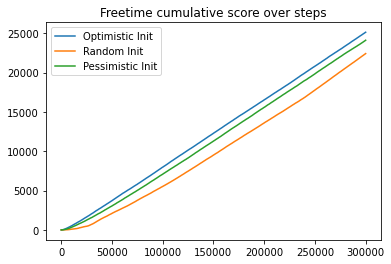

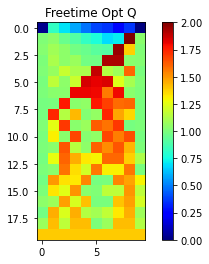

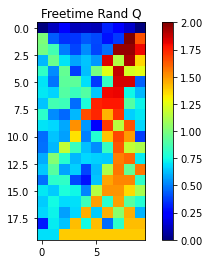

(20, 10)


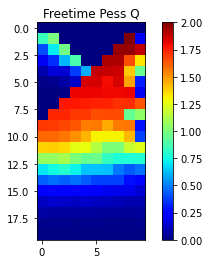

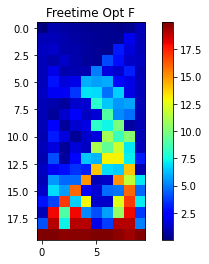

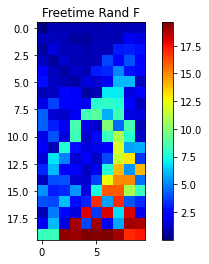

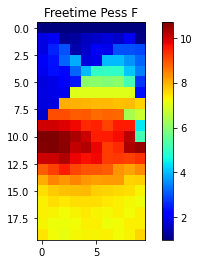

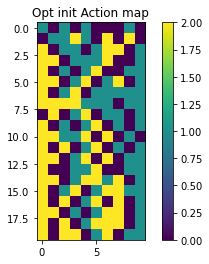

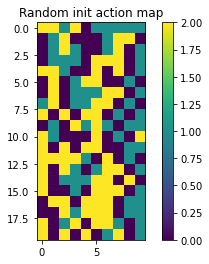

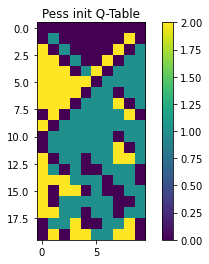

In [66]:
eps = 0.05
alpha = 0.01
steps = int(3e5)
discount = 0.98

dim = (20,10,3)

world_dim = [20,10]
rewards = [[1,0,0], [2, 0, 9]] 
config = GridworldConfig(world_dim[0], world_dim[1], rewards)

Q1 = np.ones(dim)
env = GridWorld(world_dim, rewards, randstart = True)
score_opt, Q1, F1 = play_freetime(config, steps, Q1, alpha, eps, discount)

Q2 = np.random.rand(*dim)
env = GridWorld(world_dim, rewards, randstart = True)
score_rand, Q2, F2 = play_freetime(config, steps, Q2, alpha, eps, discount)

Q3 = np.zeros(dim)

env = GridWorld(world_dim, rewards, randstart = True)
score_pess, Q3, F3 = play_freetime(config, steps, Q3, alpha, eps, discount)


plt.plot(score_opt, label= "Optimistic Init" )
plt.plot(score_rand, label= "Random Init" )
plt.plot(score_pess, label= "Pessimistic Init" )
plt.title("Freetime cumulative score over steps")
plt.legend()
plt.show()


max_opt_val = np.max(Q1,axis=2)
plt.imshow(max_opt_val[:,:], cmap="jet", vmax= 2, vmin= 0)
plt.title("Freetime Opt Q")
plt.colorbar()
plt.show()

max_opt_val = np.max(Q2,axis=2)
plt.imshow(max_opt_val[:,:], cmap="jet", vmax= 2, vmin= 0)
plt.title("Freetime Rand Q")
plt.colorbar()
plt.show()

max_opt_val = np.max(Q3,axis=2)
print(max_opt_val[:,:].shape)
plt.imshow(max_opt_val[:,:], cmap="jet", vmax= 2, vmin= 0)
plt.title("Freetime Pess Q")
plt.colorbar()
plt.show()

############################ PLOT F

max_opt_val = np.max(F1,axis=2)
plt.imshow(max_opt_val[:,:], cmap="jet")
plt.title("Freetime Opt F")
plt.colorbar()
plt.show()

max_opt_val = np.max(F2,axis=2)
plt.imshow(max_opt_val[:,:], cmap="jet")
plt.title("Freetime Rand F")
plt.colorbar()
plt.show()

max_opt_val = np.max(F3,axis=2)
plt.imshow(max_opt_val[:,:], cmap="jet")
plt.title("Freetime Pess F")
plt.colorbar()
plt.show()

###################

action_opt = np.argmax(Q1,axis=2)
plt.imshow(action_opt[:,:])
plt.colorbar()
plt.title("Opt init Action map")
plt.show()

action_rand = np.argmax(Q2,axis=2)
plt.imshow(action_rand[:,:])
plt.colorbar()
plt.title("Random init action map")
plt.show()

action_pess = np.argmax(Q3,axis=2)
plt.imshow(action_pess[:,:])
plt.colorbar()
plt.title("Pess init Q-Table")
plt.show()